In [170]:
# Austin Corgan
# ASTR 400B Research Project

# Topic: Fate of solar analogs in M31 and M33

# Question: How do the positions of solar analogs evolve? 

# Plot idea: XY plots of positions at various points in time

In [115]:
# import modules

from ReadFile import Read
from CenterOfMass2 import CenterOfMass
import numpy as np
import astropy.units as u
from astropy.constants import G
import matplotlib
import matplotlib.pyplot as plt 

G = G.to(u.kpc*u.km**2/u.s**2/u.Msun)

In [58]:
# Get center of mass of M31, M33 by making instances of CenterOfMass class at Snap 0 
# Subscript "0" will denote quantities related to Snap 0 

COMM31_0 = CenterOfMass('M31_000.txt',2) # "2" indicates use of disk particles
COMM33_0 = CenterOfMass('M33_000.txt',2)

# Get COM positions with COM_P function from CenterOfMass class

M31COMP_0 = COMM31_0.COM_P(0.1,2).value
M33COMP_0 = COMM33_0.COM_P(0.1,4).value


In [9]:
# Create function to determine magnitude of difference between two vectors 
# Here, will be used to find distance of points in galaxies from COM of that galaxy 

def magdiff(ax,ay,az,bx,by,bz):
    return np.sqrt((ax-bx)**2+(ay-by)**2+(az-bz)**2)

In [8]:
# Store data array at t = 0 using Read function, getting initial position and velocity vectors

M31time_0, M31total_0, M31data_0 = Read('M31_000.txt')
M33time_0, M33total_0, M33data_0 = Read('M33_000.txt')


In [164]:
# Make index to pick out solar analogs z
# Using distance of Sun from center of MW as 8.34 kpc (from gravity collaboration - see Lecture 4)
# Can set index to pick out particles within some delta of this radius from COM 

M31r = magdiff(M31data_0['x'],M31data_0['y'],M31data_0['z'],M31COMP_0[0],M31COMP_0[1],M31COMP_0[2])
M31index = np.where((M31data_0['type']==2) & (abs(M31r - 8.34) < 0.2))

M33r = magdiff(M33data_0['x'],M33data_0['y'],M33data_0['z'],M33COMP_0[0],M33COMP_0[1],M33COMP_0[2])
M33index = np.where((M33data_0['type']==2) & (abs(M33r - 8.34) < 0.2))

In [175]:
def SolarAnalogXYPlane(galaxy,snap):
    # This function will give the positions of all particles which began as solar analogs in a given galaxy 
    # at a given point in time
    # Inputs:
    #    galaxy - name of galaxy to examine; either 'M31' or 'M33'
    #    snap - snap number
    # Returns: 
    #    an x-y plane showing the positions of particles (which started out as solar analogs) at a given snap number 
    
    # construct corresponding file name from input 
    ilbl = '000' + str(snap)
    ilbl = ilbl[-3:]
    filename="%s_"%(galaxy) + ilbl + '.txt'
    
    # read in data from file
    time, total, data = Read(filename)
    
    # making instance of CenterOfMass class corresponding to input
    COM = CenterOfMass(filename,2)
    
    # get COM at current snap number based on galaxy (VolDec is different depending on M31 or M33)
    if (galaxy == 'M31'):
        COMP = COM.COM_P(0.1,2).value
        
    if (galaxy == 'M33'):
        COMP = COM.COM_P(0.1,4).value
        
    # get position of particles which started out as solar analogs relative to current COM
    if (galaxy == 'M31'):
        x = data['x'][M31index] - COMP[0]
        y = data['y'][M31index] - COMP[1]
        
    if (galaxy == 'M33'):
        x = data['x'][M33index] - COMP[0]
        y = data['y'][M33index] - COMP[1]
    
    # plot x-y plane
    
    fig = plt.figure(figsize=(10,10))
    ax = plt.subplot(111)

    # Plot position of particles relative to COM
    plt.scatter(x,y,color='blue',label='Positions')

    # Add chart title 
    plt.title('Position of Solar Analogs in '+ str(galaxy) + ' at t = '+ str(np.round(time.to(u.Gyr),2)),fontsize=30)

    # Add axis labels
    plt.xlabel('x (kpc)',fontsize=22)
    plt.ylabel('y (kpc)',fontsize=22)

    # set axis limits
    plt.xlim(-100,100)
    plt.ylim(-100,100)


    # add a legend
    legend = ax.legend(loc='upper right',fontsize='x-large')

In [116]:
def HernquistPotential(r,a,M):
    # Function to compute the 1990 Hernquist potential function (See lecture 4)
    # This will help in determining if a particle becomes unbound 
    # Hernquist potential is phi = -GM/(r+a)
    # Inputs: 
    #    M - total dark matter halo mass in 1e12 Msun
    #    a - scale radius in kpc
    #    r - distance from center of galaxy in kpc
    # Returns: 
    #    value of Hernquist potential at a given radius in km^2/s^2
    
    return -G*M*1e12/(r+a)
    
    

In [149]:
def PercentUnbound(galaxy,snap):
    # This function will determine the percentage of particles which started out as solar analogs which 
    # have become unbound at the given snap number. Particles will be considered unbound if they have 
    # a velocity greater than the escape velocity as determined by the Hernquist Profile phi. i.e.,
    # if v > sqrt(2*abs(phi))
    # Inputs: 
    #    galaxy - name of galaxy to examine; either 'M33' or 'M31'
    #    snap - snap number
    # Returns: 
    #    graph of percentage of solar analogs which are unbound as a function of time
    
    # construct corresponding file name from input 
    ilbl = '000' + str(snap)
    ilbl = ilbl[-3:]
    filename="%s_"%(galaxy) + ilbl + '.txt'
    
    # read in data from file
    time, total, data = Read(filename)
    
    # making instance of CenterOfMass class corresponding to input
    COM = CenterOfMass(filename,2)
    
    # get COM position at current snap number based on galaxy (VolDec is different depending on M31 or M33)
    if (galaxy == 'M31'):
        COMP = COM.COM_P(0.1,2)
        
    if (galaxy == 'M33'):
        COMP = COM.COM_P(0.1,4)
        
    # get COM velocity using COM position 
    
    COMV = COM.COM_V(COMP[0],COMP[1],COMP[2]).value
    
    COMP = COMP.value
        
    # get position of particles which started out as solar analogs relative to current COM
    if (galaxy == 'M31'):
        x = data['x'][M31index] - COMP[0]
        y = data['y'][M31index] - COMP[1]
        z = data['z'][M31index] - COMP[2]
        
    if (galaxy == 'M33'):
        x = data['x'][M33index] - COMP[0]
        y = data['y'][M33index] - COMP[1]
        z = data['z'][M33index] - COMP[2]
        
    # get distance between particle and COM
    r = np.sqrt(x**2+y**2+z**2)
    
    # get velocities of particles which started out as solar analogs relative to current COM
    if (galaxy == 'M31'):
        vx = data['vx'][M31index] - COMV[0]
        vy = data['vy'][M31index] - COMV[1]
        vz = data['vz'][M31index] - COMV[2]
        
    if (galaxy == 'M33'):
        vx = data['vx'][M33index] - COMV[0]
        vy = data['vy'][M33index] - COMV[1]
        vz = data['vz'][M33index] - COMV[2]
        
    # get magnitude of relative velocity between particle and COM
    v = np.sqrt(vx**2+vy**2+vz**2)
        
    # determine v_esc, will vary depending on galaxy, as v_esc depends on Hernquist potential, which depends on 
    # total dark matter halo mass and scale radius. Will use total halo masses for M31 (1.975e12 Msun) and 
    # M33 (0.187e12 Msun) as determined in Homework 3. Will use scale radii for M31 (62 kpc) and M33 (25 kpc) 
    # as determined in Homework 5
    
    if (galaxy == 'M31'): 
        vesc = np.sqrt(2*abs(HernquistPotential(r,62,1.975))).value
        
    if (galaxy == 'M33'):
        vesc = np.sqrt(2*abs(HernquistPotential(r,25,0.187))).value
        
    # Now count how many particles have velocity relative to the COM of the galaxy which is greater than v_esc
    
    n = 0 # initialize an index, will represent number of particles with v > vesc
    
    for i in np.arange(0,np.size(v)):
        if v[i] > vesc[i]:
            n = n+1
    
    # Divide n by total number of particles to return fraction which are unbound 
    return n/np.size(v)
    
        
    

In [169]:
def FractionGraph(galaxy,interval):
    # This function will give the fraction of unbounded particles as a function of time, where the fraction
    # unbound at any given time will be computed by the above PercentUnbound function
    # Inputs: 
    #    galaxy - either 'M31' or 'M33'
    #    interval - positive integer indicating time step in snap numbers 
    # Returns:
    #    A graph of fraction of particles unbound as a function of time
    
    return 0

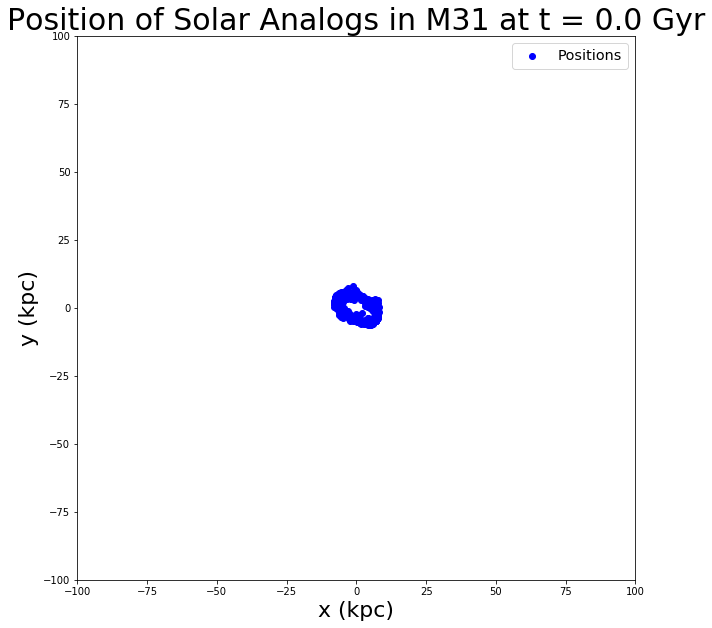

In [176]:
SolarAnalogXYPlane('M31',0)

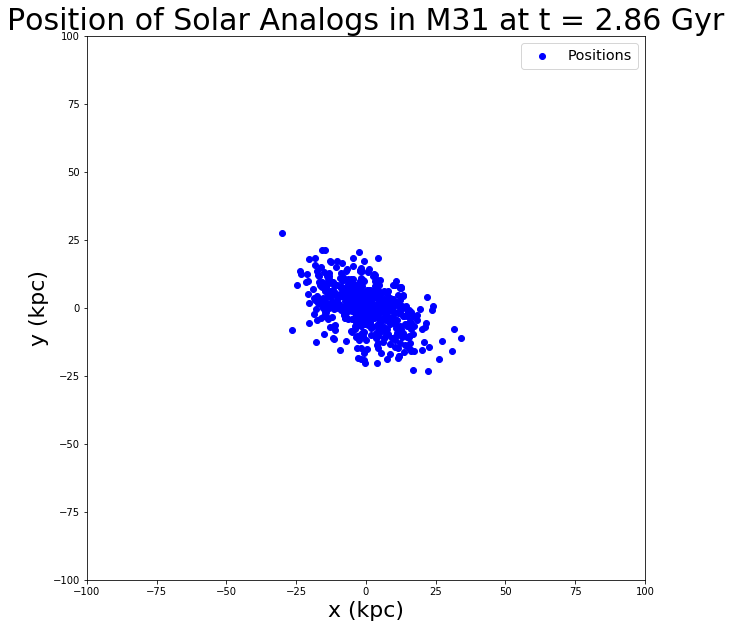

In [177]:
SolarAnalogXYPlane('M31',200)

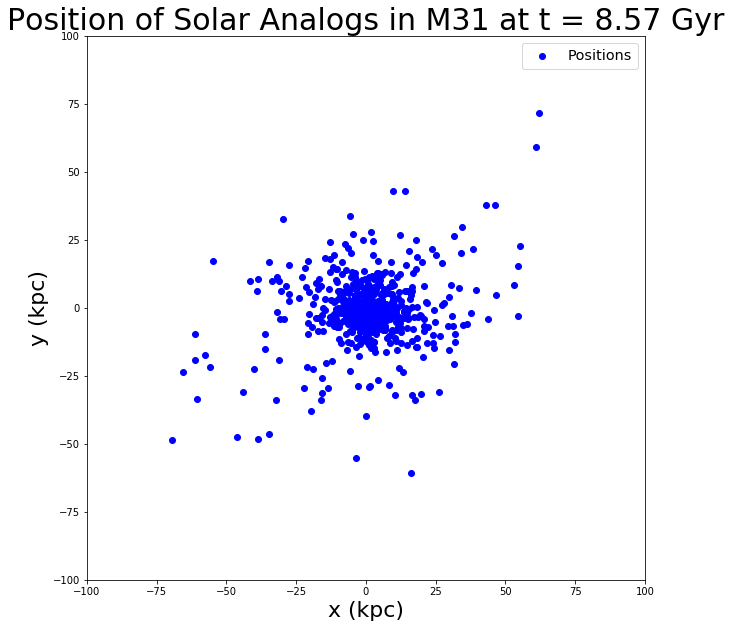

In [178]:
SolarAnalogXYPlane('M31',600)

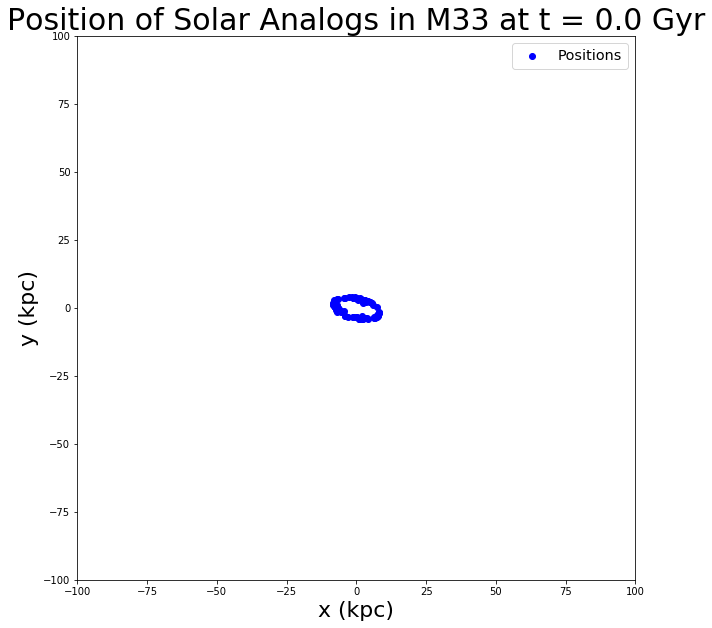

In [179]:
SolarAnalogXYPlane('M33',0)

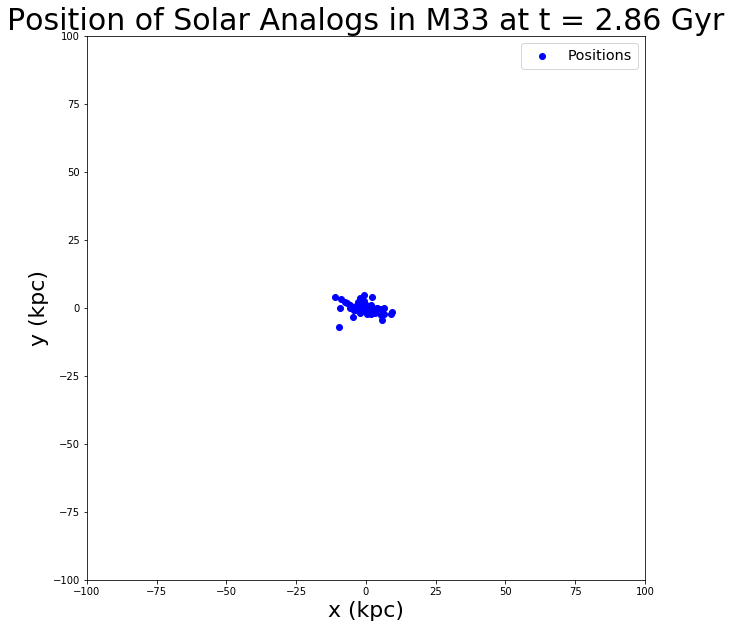

In [180]:
SolarAnalogXYPlane('M33',200)

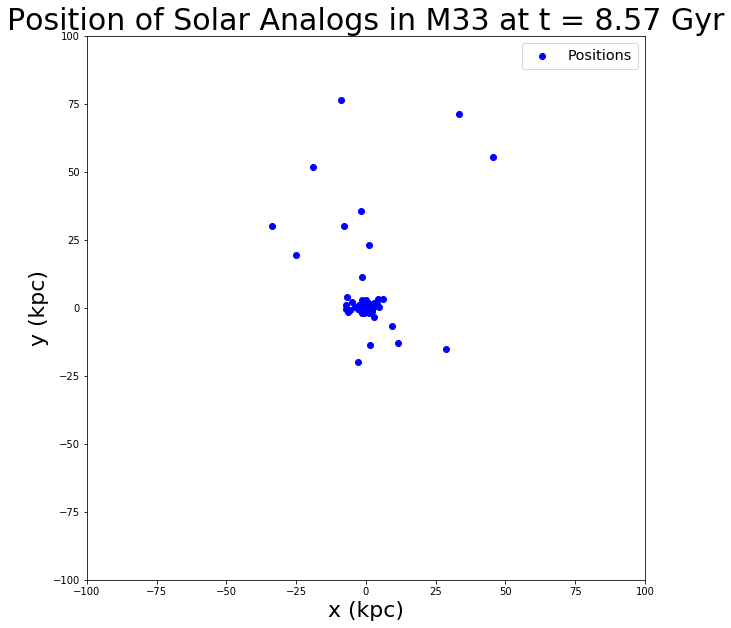

In [181]:
SolarAnalogXYPlane('M33',600)